### Import Libraries

In [1]:
# Libraries for data processing and math 
import pandas as pd
import numpy as np

# Library for plotting 
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# Library for file path manipulation 
import os

# Libraries for machine learning algorithms 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Set seed to control randomness
np.random.seed(156)

### Read in the cleaned data

In [2]:
# This gets the file path of the data folder in EnvCausal-replication 
root = os.path.dirname(os.getcwd())
data_dir = os.path.join(root, 'data')

# Set the file path for the cleaned snapshot data set
snapshot_path = os.path.join(data_dir, 'cleaned_snapshot_data.csv')

# Read snapshots data set 
snapshots = pd.read_csv(snapshot_path, index_col=0).reset_index().iloc[:, 1:]

### Perform Data Preprocessing

In [3]:
# Scale the data 
scaler = StandardScaler()
city_labels = snapshots.iloc[:, 0]
scaled_snapshots = scaler.fit_transform(snapshots.iloc[:, 1:])

### Principal Components Analysis

In [4]:
# Perform Principal Components Analysis 
n_components = scaled_snapshots.shape[1] 
pca = PCA(n_components=n_components, svd_solver='full')
pca.fit(scaled_snapshots)
# Separately fit PCA with 3 components following paper 
pca_reduce = PCA(n_components=3, svd_solver='full') # project data onto 3 dimensions, as in paper 
pca_reduce.fit(scaled_snapshots)
snapshots_pca_3 = pca_reduce.transform(scaled_snapshots)
city_df = pd.DataFrame({'City':city_labels})
pca_df = pd.DataFrame(snapshots_pca_3)
projection_df = pd.concat([city_df, pca_df], axis=1).set_index('City')
explained_variances = pca.explained_variance_ratio_
var_by_pc_num = np.cumsum(np.round(explained_variances, decimals=3)*100)

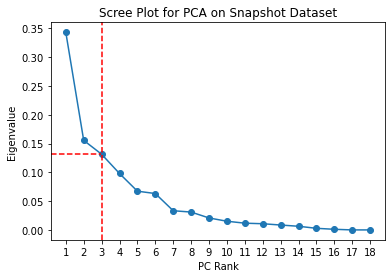

In [5]:
# Scree Plot
plt.title('Scree Plot for PCA on Snapshot Dataset')
plt.xlabel('PC Rank')
plt.ylabel('Eigenvalue')
plt.xticks(np.arange(1, n_components+1))
plt.plot(np.arange(1, n_components+1), explained_variances)
plt.axvline(x=3, color='r', linestyle='dashed')
plt.axhline(y=explained_variances[2], xmin=0, xmax=0.15, color='r', linestyle='dashed')
plt.scatter(np.arange(1, n_components+1), explained_variances);

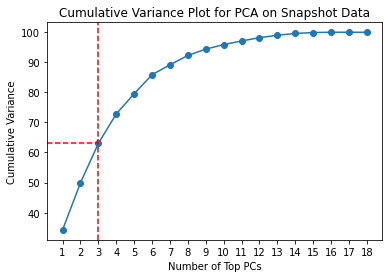

In [6]:
# Cumulative Variance by PCs
plt.title('Cumulative Variance Plot for PCA on Snapshot Data')
plt.xlabel('Number of Top PCs')
plt.ylabel('Cumulative Variance')
plt.yticks(np.arange(0, 101, 10))
plt.xticks(np.arange(1, n_components+1))
plt.plot(np.arange(1, n_components+1), var_by_pc_num)
plt.axvline(x=3, color='r', linestyle='dashed')
plt.axhline(y=var_by_pc_num[2], xmin=0, xmax=0.15, color='r', linestyle='dashed')
plt.scatter(np.arange(1, n_components+1), var_by_pc_num);

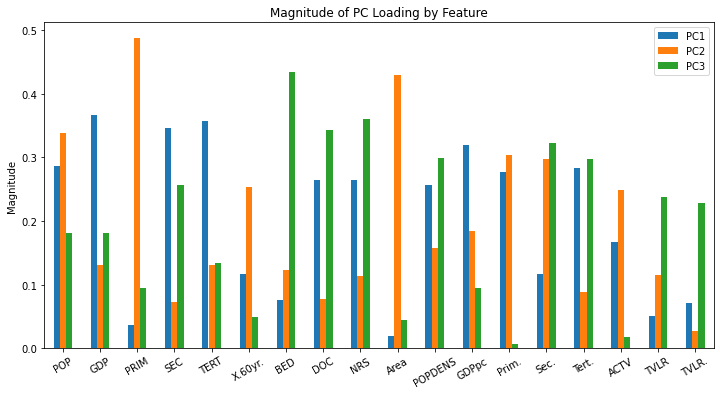

In [7]:
# Generate plot of Magnitude of features present in top 3 PCs (Figure S1) 
# Extract PC loadings 
pca_3comp_df = pd.DataFrame(pca_reduce.components_)
pca_3comp_df.columns = snapshots.columns[1:]
cleaned_pca_3_df = pca_3comp_df.T.reset_index()
cleaned_pca_3_df.columns = ['Variables', 'PC1', 'PC2', 'PC3']
cleaned_pca_3_df = cleaned_pca_3_df.apply(
    lambda x: np.abs(x) if x.name != 'Variables' else x)
cleaned_pca_3_df.plot(x="Variables", y=['PC1', 'PC2', 'PC3'], kind="bar",
                     figsize=(12,6), rot=30)
plt.title('Magnitude of PC Loading by Feature')
plt.ylabel('Magnitude')
plt.xlabel('');

### k-Means Clustering for City Stratification

In [8]:
def drawSSEPlot(df, column_indices, n_clusters=8, max_iter=300, tol=1e-04, init='k-means++', n_init=10, algorithm='auto'):
    import matplotlib.pyplot as plt
    inertia_values = []
    for i in range(1, n_clusters+1):
        km = KMeans(n_clusters=i, max_iter=max_iter, tol=tol, init=init, n_init=n_init, random_state=1, algorithm=algorithm)
        km.fit_predict(df.iloc[:, column_indices])
        inertia_values.append(km.inertia_)
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.plot(range(1, n_clusters+1), inertia_values, color='red')
    plt.xlabel('No. of Clusters', fontsize=15)
    plt.ylabel('SSE / Inertia', fontsize=15)
    plt.title('SSE / Inertia vs No. Of Clusters', fontsize=15)
    plt.grid()
    plt.show()

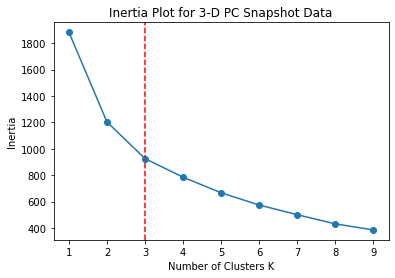

In [9]:
# k-Means Inertia plot (Figure S2)
inertias = []
n_clusters_test = 9 # test up to 9 clusters in the snapshot data
clusters_to_try = np.arange(1, n_clusters_test+1)
for i in clusters_to_try:
    km = KMeans(n_clusters=i)
    km.fit_predict(projection_df)
    curr_inertia = km.inertia_
    inertias.append(curr_inertia)
plt.title('Inertia Plot for 3-D PC Snapshot Data')
plt.xlabel('Number of Clusters K')
plt.ylabel('Inertia')
plt.axvline(x=3, color='r', linestyle='dashed')
plt.scatter(clusters_to_try, inertias)
plt.plot(clusters_to_try, inertias);

In [10]:
# Final k-Means clustering 
num_clusters = 3 # generate 3 clusters of cities, consistent with the paper 
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(projection_df)
predicted_clusters = kmeans.labels_
cluster_projection_df = projection_df.copy()
cluster_projection_df['Cluster'] = predicted_clusters

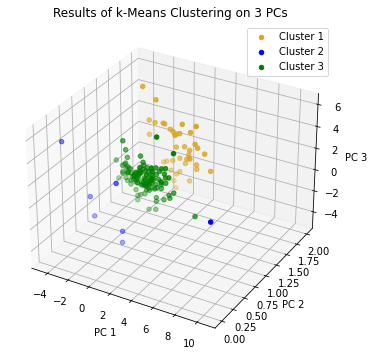

In [11]:
# Plot of clustered data in PC space (Figure S3)
cluster_1 = cluster_projection_df[cluster_projection_df['Cluster'] == 0]
cluster_2 = cluster_projection_df[cluster_projection_df['Cluster'] == 1]
cluster_3 = cluster_projection_df[cluster_projection_df['Cluster'] == 2]

# Keep PC indexing consistent with notation in paper 
x1 = cluster_1.iloc[:, 1]
y1 = cluster_1.iloc[:, 3]
z1 = cluster_1.iloc[:, 2]
x2 = cluster_2.iloc[:, 1]
y2 = cluster_2.iloc[:, 3]
z2 = cluster_2.iloc[:, 2]
x3 = cluster_3.iloc[:, 1]
y3 = cluster_3.iloc[:, 3]
z3 = cluster_3.iloc[:, 2]

fig = plt.figure(figsize = (6, 6))
ax = plt.axes(projection ="3d")
# Keep cluster labeling consistent with results in paper 
ax.scatter3D(x3, y3, z3, color = "goldenrod", label='Cluster 1')
ax.scatter3D(x1, y1, z1, color = "blue", label='Cluster 2')
ax.scatter3D(x2, y2, z2, color = "green", label='Cluster 3')

#plt.xticks(np.arange(-2,11,2))
#plt.yticks(np.arange(-5, 11, 2.5)) # weird decision, since this compresses clusters together
#ax.set_zticks(np.arange(-4, 7, 2))
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.legend()
ax.view_init(azim=-60, elev=30)
plt.title("Results of k-Means Clustering on 3 PCs");